In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Conv2D, Dropout, Flatten

from pandas import DataFrame

%matplotlib inline

## Set some values globally
# Ticks label size
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size     
mpl.rcParams['ytick.labelsize'] = label_size
# Ticks width
ticks_width = 0.5
mpl.rcParams['xtick.major.width'] = ticks_width
mpl.rcParams['ytick.major.width'] = ticks_width
# Line width
mpl.rcParams['axes.linewidth'] = 0.5

Using TensorFlow backend.


### 2D Ising Gauge Hamiltonian:
\begin{equation}
H = -J \sum_p \prod_{i\in p} S^z_i
\end{equation}

In [23]:
def plot_configuration(spins, dual=False):
    '''
    Helper function to plot the configuration of spins given by `spins`.
    
    Note: (i,j) denotes a vertex coordinate, such that the location of 
    the plaquette center is at (i+0.5, j+0.5) and thus, the spin is 
    at (i+1, j+0.5).
    
    Arguments: 
        spins -- a spin configuration; type: numpy array of shape (N, N, 2).
        dual -- whether to plot the spin configuration in dual space;
                type: bool; default: False.
    '''
    N = np.shape(spins)[1]
    
    fig, ax = plt.subplots(dpi=100, figsize=(5, 5))
    fig.add_axes()
    ax = fig.axes[0]
    
    # Plot lattice (grid).
    for i in range(N+1):
        ax.plot([i, i], [0, N], 'k', lw=0.5)
        ax.plot([0, N], [i, i], 'k', lw=0.5)
    
    # Standard plot
    if not dual:
        # Plot spins (circles).
        colors = ['C0', 'C1']  # blue: down, orange: up.
        for i in range(N):
            fig.gca().add_patch(plt.Circle((0,i+0.5), radius=0.2, fc=colors[int((spins[-1, i, 0]+1)/2.)],
                                          ec='k', lw=0.3))
            fig.gca().add_patch(plt.Circle((i+0.5,0), radius=0.2, fc=colors[int((spins[i, -1, 1]+1)/2.)],
                                          ec='k', lw=0.3))
            for j in range(N):
                fig.gca().add_patch(plt.Circle((i+1,j+0.5), radius=0.2, fc=colors[int((spins[i, j, 0]+1)/2.)],
                                              ec='k', lw=0.3))
                fig.gca().add_patch(plt.Circle((i+0.5,j+1), radius=0.2, fc=colors[int((spins[i, j, 1]+1)/2.)],
                                              ec='k', lw=0.3))
    
    # Dual space plot
    if dual:
        excitation = []
        for i in range(N):
            if spins[-1, i, 0] == 1: 
                ax.plot([-0.5, 0.5], [i+0.5, i+0.5], 'C2', lw=2)
            if spins[i, -1, 1] == 1: 
                ax.plot([i+0.5, i+0.5], [-0.5, 0.5], 'C2', lw=2)
            for j in range(N):
                j_up = (N+j-1)%N
                i_left = (i+N-1)%N
                if spins[i, j, 0] == 1: 
                    ax.plot([i+0.5, i+1.5], [j+0.5, j+0.5], 'C2', lw=2)
                if spins[i, j, 1] == 1: 
                    ax.plot([i+0.5, i+0.5], [j+0.5, j+1.5], 'C2', lw=2)
                if spins[i, j, 0]*spins[i_left, j, 0]*spins[i, j, 1]*spins[i, j_up, 1] == -1: 
                    excitation.append([i+0.5, j+0.5])
                    
        if len(excitation) > 0: 
            plt.scatter(np.array(excitation)[:, 0], np.array(excitation)[:, 1], color='C3', s=100, marker=(5,1))
            
    ax.set_ylim(-1,N+1)
    ax.set_xlim(-1,N+1)
    ax.set_aspect('equal')
    
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.axis('off')
#     fig.show()
    if dual==True:
        plt.savefig('ising_gauge_dual.png', bbox_inches='tight', dpi=600)
    else:
        plt.savefig('ising_gauge.png', bbox_inches='tight', dpi=600)

First we need to create training and test configurations with the script **create_configurations.py**, then run the next cells.

In [4]:
# Training set.
train_configs = np.loadtxt("configs/train_configs.txt")
train_labels = np.loadtxt("configs/train_labels.txt")
N = int(np.sqrt(np.shape(train_configs[0])[0]/2))
print("Loaded %i configurations of size %ix%i for training."%(len(train_configs), N,N))

Loaded 2000 configurations of size 16x16 for training.


In [5]:
# Test set.
test_config = np.loadtxt("configs/test_configs.txt")
test_labels = np.loadtxt("configs/test_labels.txt")
N = int(np.sqrt(np.shape(test_config[0])[0]/2))
print("Loaded %i test configurations of size %ix%i for testing."%(len(test_config), N,N))

Loaded 1000 test configurations of size 16x16 for testing.


In [6]:
# Prepare data for training
x = train_configs
y = np.array([(i%2,(i+1)%2) for i in train_labels])

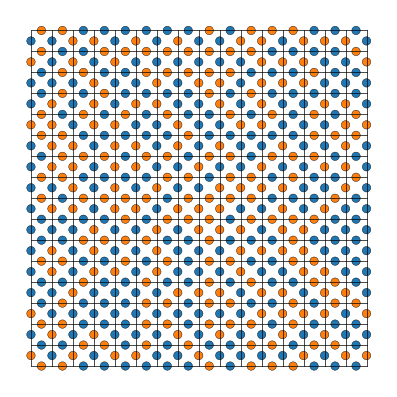

In [15]:
# Standard plot
plot_configuration(np.reshape(train_configs[0], (N, N, 2)))

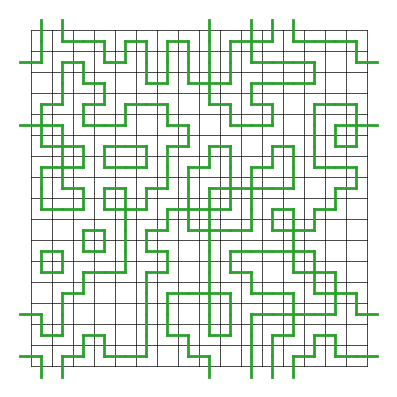

In [20]:
# Dual space plot
plot_configuration(np.reshape(train_configs[0], (N, N, 2)), dual=True)

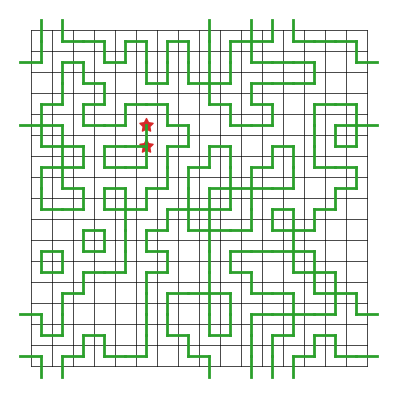

In [24]:
# Show how excitations/defects are shown in 'dual' space
single_excitation = np.copy(train_configs[0])
i = 11
j = 5
single_excitation[i*N+j] *= -1
plot_configuration(np.reshape(single_excitation, (N, N, 2)), dual=True)

## Dense network - 1st try

In [47]:
# Create simple model.
# Network architecture: input layer, hidden layer with 32 neurons, and output layer with 2 neurons.

model = Sequential()
model.add(Dense(32, input_dim=2*N**2, kernel_initializer='glorot_normal', activation='sigmoid', 
                kernel_regularizer=regularizers.l2(0.02)))
model.add(Dense(2, kernel_initializer='glorot_normal', activation='softmax', 
                kernel_regularizer=regularizers.l2(0.01)))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 16,482
Trainable params: 16,482
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Train model.
model.fit(x, y, epochs=25, batch_size=32)

Epoch 1/25
2000/2000 [==============================] - 0s 105us/step - loss: 1.4993 - accuracy: 0.5035
Epoch 2/25
2000/2000 [==============================] - 0s 51us/step - loss: 0.9708 - accuracy: 0.5940
Epoch 3/25
2000/2000 [==============================] - 0s 51us/step - loss: 0.8036 - accuracy: 0.6415
Epoch 4/25
2000/2000 [==============================] - 0s 48us/step - loss: 0.7426 - accuracy: 0.6455
Epoch 5/25
2000/2000 [==============================] - 0s 48us/step - loss: 0.7163 - accuracy: 0.6540
Epoch 6/25
2000/2000 [==============================] - 0s 56us/step - loss: 0.7027 - accuracy: 0.6615
Epoch 7/25
2000/2000 [==============================] - 0s 59us/step - loss: 0.6965 - accuracy: 0.6600
Epoch 8/25
2000/2000 [==============================] - 0s 68us/step - loss: 0.6920 - accuracy: 0.6620
Epoch 9/25
2000/2000 [==============================] - 0s 56us/step - loss: 0.6877 - accuracy: 0.6555
Epoch 10/25
2000/2000 [==============================] - 0s 60us/step - 

In [12]:
# Prepare data for testing.
test_y = np.array([(i%2, (i+1)%2) for i in test_labels])

In [49]:
# Evaluate model.
predictions = model.predict(test_config)
preds = model.evaluate(x=test_config, y=test_y)

print ("Loss = {0:.3f}".format(preds[0]))
print ("Test Accuracy = {0:.3f}".format(preds[1]))

1000/1000 [==============================] - 0s 42us/step
Loss = 0.787
Test Accuracy = 0.487


The simple, fully-connected NN doesn't perform better than random chance (coin toss)...

## Larger/deeper dense network - 2nd try

In [54]:
# Create bigger and deeper model.
# Network architecture: input layer, hidden layer #1 with 64 neurons, 
# hidden layer #2 with 16 neurons, and output layer with 2 neurons.

model2 = Sequential()
model2.add(Dense(64, input_dim=2*N**2, kernel_initializer='glorot_normal', activation='sigmoid', 
                 kernel_regularizer=regularizers.l2(0.02)))
model2.add(Dense(16, kernel_initializer='glorot_normal', activation='sigmoid', 
                 kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(2, kernel_initializer='glorot_normal', activation='softmax', 
                 kernel_regularizer=regularizers.l2(0.01)))

# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
# Train model.
model2.fit(x, y, epochs=25, batch_size=32) 

Epoch 1/25
2000/2000 [==============================] - 0s 110us/step - loss: 2.0633 - accuracy: 0.4820
Epoch 2/25
2000/2000 [==============================] - 0s 64us/step - loss: 1.0510 - accuracy: 0.5315
Epoch 3/25
2000/2000 [==============================] - 0s 66us/step - loss: 0.8478 - accuracy: 0.5785
Epoch 4/25
2000/2000 [==============================] - 0s 63us/step - loss: 0.7954 - accuracy: 0.5750
Epoch 5/25
2000/2000 [==============================] - 0s 63us/step - loss: 0.7718 - accuracy: 0.5805
Epoch 6/25
2000/2000 [==============================] - 0s 64us/step - loss: 0.7588 - accuracy: 0.5735
Epoch 7/25
2000/2000 [==============================] - 0s 60us/step - loss: 0.7486 - accuracy: 0.5845
Epoch 8/25
2000/2000 [==============================] - 0s 66us/step - loss: 0.7410 - accuracy: 0.6030
Epoch 9/25
2000/2000 [==============================] - 0s 65us/step - loss: 0.7383 - accuracy: 0.5395
Epoch 10/25
2000/2000 [==============================] - 0s 60us/step - 

In [56]:
# Evaluate model.
predictions2 = model2.predict(test_config)
preds2 = model2.evaluate(x=test_config, y=test_y)

print ("Loss = {0:.3f}".format(preds2[0]))
print ("Test Accuracy = {0:.3f}".format(preds2[1]))

1000/1000 [==============================] - 0s 59us/step
Loss = 0.708
Test Accuracy = 0.500


Again, pure random chance!

## Convolutional NN (CNN) - 3rd try

In [7]:
# Reshape the configurations to fit the input layer of a CNN.
x = np.array([np.reshape(config, (N, N, 2)) for config in train_configs])

In [8]:
def create_periodic_padding(configs, kernel_size):
    """
    Periodic `padding` for the spin configurations.
    
    Arguments:
        configs -- spin configuration; shape: NxNx2; type: (int, int, 2).
        kernel_size -- filter size; type: int.

    Returns:
        x -- padded spin configurations.
    """
    
    N = np.shape(configs)[1]
    padding = kernel_size-1  # Padding size
    
    x = []
    
    for config in configs:
        # Tensor to store padded configurations
        padded = np.zeros((N+2*padding, N+2*padding, 2))
        # Lower left corner
        padded[:padding, :padding, :] = config[N-padding:, N-padding:, :]
        # Lower middle
        padded[padding:N+padding, :padding, :] = config[:, N-padding:, :]
        # Lower right corner
        padded[N+padding:, :padding, :] = config[:padding, N-padding:, :]
        # Left side
        padded[:padding, padding:N+padding, :] = config[N-padding:, :, :]
        # Center
        padded[padding:N+padding, padding:N+padding, :] = config[:, :, :]
        # Right side
        padded[N+padding:, padding:N+padding, :] = config[:padding, :, :]
        # Top left corner
        padded[:padding, N+padding:, :] = config[N-padding:, :padding, :]
        # Top middle
        padded[padding:N+padding, N+padding:, :] = config[:, :padding, :]
        # Top right corner
        padded[N+padding:, N+padding:, :] = config[:padding, :padding, :]
        
        x.append(padded)
        
    return np.array(x)

In [9]:
# Create CNN model.
# Network architecture: input layer, hidden conv. layer (#1) with 64 filters, 
# hidden fully connected layer (#2) with 64 neurons, and output layer with 2 neurons.

def convolutional_model(kernel_size):
    input_size = 16+2*(kernel_size-1)
    
    model = Sequential()
    # [Conv. + Relu] block
    model.add(Conv2D(64, (kernel_size, kernel_size), strides=1, input_shape=(input_size, input_size, 2), 
                     activation='relu'))
    # [Flatten (i.e. convert to vector) + fully connected] block
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    # Dropout regularization
    model.add(Dropout(0.2))
    # Softmax output layer
    model.add(Dense(2, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# Prepare data for testing.
test_x = np.array([np.reshape(config, (N, N, 2)) for config in test_config])

In [13]:
# Train models (this will take a while).
kernel_sizes = [2, 3, 4, 5, 6]
accuracy = []
runs = 10  # Number of runs per kernel size

for kernel_size in kernel_sizes:
    print("Kernel size is %ix%i"%(kernel_size, kernel_size))
    print('-------------------\n')
    
    x_n = create_periodic_padding(x, kernel_size)
    test_x_n = create_periodic_padding(test_x, kernel_size)
    
    for i in range(runs):
        print("run %i of %i"%(i+1, runs))
        
        # Create CNN model.
        model = convolutional_model(kernel_size)
        # Train model.
        model.fit(x_n, y, epochs=20, batch_size=32, verbose=0)
        
        # Evaluate model.
        preds = model.evaluate(test_x_n, test_y, verbose=0)
        acc = preds[1]
        accuracy.append(acc)
        print("Test accuracy = {0:.3f}".format(acc))
    print(' ')

Kernel size is 2x2
-------------------

run 1 of 10
Test accuracy = 1.000
run 2 of 10
Test accuracy = 1.000
run 3 of 10
Test accuracy = 0.996
run 4 of 10
Test accuracy = 1.000
run 5 of 10
Test accuracy = 1.000
run 6 of 10
Test accuracy = 1.000
run 7 of 10
Test accuracy = 1.000
run 8 of 10
Test accuracy = 1.000
run 9 of 10
Test accuracy = 1.000
run 10 of 10
Test accuracy = 1.000
 
Kernel size is 3x3
-------------------

run 1 of 10
Test accuracy = 1.000
run 2 of 10
Test accuracy = 1.000
run 3 of 10
Test accuracy = 1.000
run 4 of 10
Test accuracy = 1.000
run 5 of 10
Test accuracy = 0.992
run 6 of 10
Test accuracy = 1.000
run 7 of 10
Test accuracy = 1.000
run 8 of 10
Test accuracy = 1.000
run 9 of 10
Test accuracy = 1.000
run 10 of 10
Test accuracy = 0.999
 
Kernel size is 4x4
-------------------

run 1 of 10
Test accuracy = 0.893
run 2 of 10
Test accuracy = 0.869
run 3 of 10
Test accuracy = 0.514
run 4 of 10
Test accuracy = 0.911
run 5 of 10
Test accuracy = 0.743
run 6 of 10
Test accurac

In [19]:
acc = np.reshape(np.array(accuracy), (len(kernel_sizes), runs))

In [24]:
accur = {}

# Get accuracies per kernel size
for j, k in enumerate(kernel_sizes):
    accur['{}'.format(k)] = acc[j]

In [25]:
results = DataFrame(accur)
print(results.describe())

               2          3          4          5          6
count  10.000000  10.000000  10.000000  10.000000  10.000000
mean    0.999600   0.999100   0.732800   0.510000   0.498800
std     0.001265   0.002514   0.188457   0.044803   0.009283
min     0.996000   0.992000   0.500000   0.484000   0.486000
25%     1.000000   1.000000   0.531750   0.490000   0.490750
50%     1.000000   1.000000   0.788000   0.496500   0.500000
75%     1.000000   1.000000   0.887000   0.501750   0.504000
max     1.000000   1.000000   0.974000   0.635000   0.513000


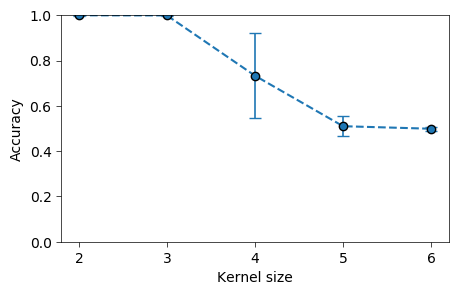

In [84]:
fig = plt.figure(dpi=100, figsize=(5, 3))

plt.errorbar(results.columns, results.mean(), yerr=results.std(),
             ls='--', marker='o', markeredgecolor='k', elinewidth=1.2, capsize=4)

plt.xlabel("Kernel size")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

# plt.show()
plt.savefig("kernel_sizes_acc.png", bbox_inches='tight', dpi=600)